In [1]:
#поставим lablelimg
#должен быть скачан git
#https://gitforwindows.org/

import os
!pip install pyqt5 lxml
LABELIMG_PATH = os.path.join("krasnoteh_OD", "labelimg")
if not os.path.exists(LABELIMG_PATH):
    !mkdir {LABELIMG_PATH}
    !git clone https://github.com/tzutalin/labelImg {LABELIMG_PATH}
    if os.name == 'posix':
        !make qt5py3
    if os.name =='nt':
        !cd {LABELIMG_PATH} && pyrcc5 -o libs/resources.py resources.qrc

In [2]:
#запуск программы
!cd {LABELIMG_PATH} && python labelImg.py

Image:C:\Users\user\AI tests\krasnoteh_OD\images\test.png -> Annotation:C:/Users/user/AI tests/krasnoteh_OD/images\test.xml
Image:C:\Users\user\AI tests\krasnoteh_OD\images\test.png -> Annotation:C:/Users/user/AI tests/krasnoteh_OD/images\test.xml


In [3]:
#поработаем с XML форматом
import xml.etree.ElementTree as ET
tree = ET.parse('C:/Users/user/AI tests/krasnoteh_OD/images/test.xml') #адрес файла
root=tree.getroot()   #парсим

In [4]:
#вот так ориентируемся в файле
print(root[1].tag, root[1].text)
print(root[2].tag, root[2].text)
print(root[4][0].tag, root[4][0].text)
print(root[4][1].tag, root[4][1].text)

filename test.png
path C:\Users\user\AI tests\krasnoteh_OD\images\test.png
width 100
height 100


In [5]:
#сколько обьектов размечено? (6 - кол-во служебных элементов, таких как размер, название и т.д)
num_objects = len(root)-6
print(num_objects)

2


In [6]:
for num in range(num_objects):
    print(root[num+6][0].tag)
    print(root[num+6][4][0].tag)

name
xmin
name
xmin


In [7]:
#импортируем разное
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


ball
ball
[[0.26, -0.26, 0.72, 0.19999999999999996], [-0.5, -0.96, 0.10000000000000009, -0.33999999999999997]]


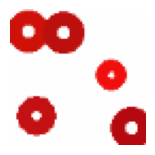

In [8]:
#обработаем одну картинку

def load_img(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)/256
    img = tf.image.resize(img,(64,64))
    return img

tree = ET.parse('C:/users/user/AI tests/krasnoteh_OD/images/test.xml') #адрес файла
root=tree.getroot()   #парсим
num_objects = len(root)-6
cords = []
w = int(root[4][0].text) #ширина x
h = int(root[4][1].text) #высота y

for num in range(num_objects):
    print(root[num+6][0].text) #имя обьекта
    
    object_cords = []
    #нормализуем координаты от -1 до 1, опираясь на исходные координаты
    object_cords.append(int(root[num+6][4][0].text)/w*2-1)
    object_cords.append(int(root[num+6][4][1].text)/h*2-1)
    object_cords.append(int(root[num+6][4][2].text)/w*2-1)
    object_cords.append(int(root[num+6][4][3].text)/h*2-1)
    
    cords.append(object_cords)
print(cords)

img = load_img(root[2].text)
plt.figure(figsize=(10, 6))
ax = plt.subplot(3, 1, 1)
plt.imshow(img)
plt.axis('off')
plt.show()    

In [11]:
#преобразуем папку в tfrecord
#так чтение датасета и обучение будет быстрее

fn = "C:/users/user/AI tests/krasnoteh_OD/images"
#формируем список всех xml файлов в папке
p = [fn + '/' + f for f in listdir(fn) if isfile(join(fn, f)) and f[-1] == 'l'] 
print(p[:5])

    
def load_img(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)/256
    img = tf.image.resize(img,(64,64))
    return img
    
#создаем запись
writer = tf.io.TFRecordWriter('bounding_box_dataset.tfrecord')



for xml in p:
    tree = ET.parse(xml) #адрес файла
    root=tree.getroot()   #парсим
    num_objects = len(root)-6
    cords = []
    w = int(root[4][0].text) #ширина x
    h = int(root[4][1].text) #высота y
    for num in range(num_objects):
        object_cords = []
        #нормализуем координаты от -1 до 1, опираясь на исходные координаты
        object_cords.append(int(root[num+6][4][0].text)/w*2-1)
        object_cords.append(int(root[num+6][4][1].text)/h*2-1)
        object_cords.append(int(root[num+6][4][2].text)/w*2-1)
        object_cords.append(int(root[num+6][4][3].text)/h*2-1)
        cords.append(object_cords)

    img = load_img(root[2].text)
    #готовим данные, представляем в байтовом виде
    serialized_img = tf.io.serialize_tensor(img).numpy()
    serialized_cords = tf.io.serialize_tensor(cords).numpy()
    #собираем экзепмляр
    example = tf.train.Example(features=tf.train.Features(feature={
        'img': tf.train.Feature(bytes_list=tf.train.BytesList(value=[serialized_img])),
        'cords': tf.train.Feature(bytes_list=tf.train.BytesList(value=[serialized_cords]))
    }))

    #записываем в запись
    writer.write(example.SerializeToString())


writer.close()

['C:/users/user/AI tests/krasnoteh_OD/images/test_0.xml', 'C:/users/user/AI tests/krasnoteh_OD/images/test_1.xml', 'C:/users/user/AI tests/krasnoteh_OD/images/test_10.xml', 'C:/users/user/AI tests/krasnoteh_OD/images/test_100.xml', 'C:/users/user/AI tests/krasnoteh_OD/images/test_101.xml']


In [12]:
#прочитаем запись
dataset = tf.data.TFRecordDataset('bounding_box_dataset.tfrecord')


def parse_record(record):
    #нужно описать приходящий экземпляр
    #имена элементов как при записи
    feature_description = {
        'img': tf.io.FixedLenFeature([], tf.string),
        'cords': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_record = tf.io.parse_single_example(record, feature_description)
    img = tf.io.parse_tensor(parsed_record['img'], out_type=tf.float32)
    cords = tf.io.parse_tensor(parsed_record['cords'], out_type=tf.float32)
    return img, cords

#пройдемся по записи и распакуем ее
dataset = dataset.map(parse_record)

#что-нибудь выведем
for i, c in dataset.take(1):
    print(i.shape)
    print(c.shape)

(64, 64, 3)
(5, 4)
